In [1]:
!pip install MIDIUtil
!apt install ffmpeg timidity

     |████████████████████████████████| 1.0 MB 3.7 MB/s 
  Created wheel for MIDIUtil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=3dae2b4d41c5d105aa8764437ff7d027268bd376289ff3d76e89b5d4b27a4769
  Stored in directory: /root/.cache/pip/wheels/e3/97/cd/a677b61a76d575f373e2e10302f1d9106507fea6dd1320df03
Successfully built MIDIUtil
Reading package lists... Done
Building dependency tree       
Reading state information... Done
ffmpeg is already the newest version (7:3.4.8-0ubuntu0.2).
The following additional packages will be installed:
  freepats libaudio2 timidity-daemon
Suggested packages:
  nas fluid-soundfont-gm fluid-soundfont-gs pmidi
The following NEW packages will be installed:
  freepats libaudio2 timidity timidity-daemon
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 29.6 MB of archives.
After this operation, 35.7 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 freepats all 2006021

In [2]:
import tensorflow as tf
try:
  tpu_resolver = tf.distribute.cluster_resolver.TPUClusterResolver() # TPU detection
except ValueError:
  tpu_resolver = None
  gpus = tf.config.experimental.list_logical_devices("GPU")

# Select appropriate distribution strategy
if tpu_resolver:
  tf.config.experimental_connect_to_cluster(tpu_resolver)
  tf.tpu.experimental.initialize_tpu_system(tpu_resolver)
  strategy = tf.distribute.experimental.TPUStrategy(tpu_resolver)
  print('Running on TPU ', tpu_resolver.cluster_spec().as_dict()['worker'])
elif len(gpus) > 1:
  strategy = tf.distribute.MirroredStrategy([gpu.name for gpu in gpus])
  print('Running on multiple GPUs ', [gpu.name for gpu in gpus])
elif len(gpus) == 1:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on single GPU ', gpus[0].name)
else:
  strategy = tf.distribute.get_strategy() # default strategy that works on CPU and single GPU
  print('Running on CPU')
  
print("Number of accelerators: ", strategy.num_replicas_in_sync)

Running on single GPU  /device:GPU:0
Number of accelerators:  1


In [3]:
audio_path = "/content/drive/MyDrive/Colab Notebooks/Exp2_per-note_training/"

In [4]:
import librosa 
import numpy as np
from midiutil import MIDIFile
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

In [5]:
notes = np.arange(36,96,1)
# # channels = np.arange(1,121,1)
channels = np.concatenate((np.arange(1,49,1),
                     np.arange(57,81,1),
                     np.arange(105,121,1),
))

# notes = np.arange(36,40,1)
# channels =np.arange(1,20,1)


total_size=notes.shape[0]*channels.shape[0]
total_size,notes.shape,channels.shape

(5280, (60,), (88,))

In [6]:
!mkdir midis
!mkdir midis/wav/
!mkdir midis/mid/

In [7]:
# !rm -rf midis/*

In [8]:
# Create a two-track file
midi_notes = []

for fn in range(len(channels)):
  MyMIDI = MIDIFile(1, adjust_origin=False)
  MyMIDI.addTempo(0,0,120)
  midi = []

  # for i in range(16):
  MyMIDI.addProgramChange(0, 0, 0, fn)

  duration = 1
  for i,n in enumerate(notes):
    track = 0
    channel = 0
    time = i*duration
    pitch = n
    volume = 100

    MyMIDI.addNote(track, channel, pitch, time, duration, volume)
    midi.append([n])
  midi_notes.append(midi)
  
  with open("midis/output_"+str(fn).zfill(2)+".mid", 'wb') as binfile:
      MyMIDI.writeFile(binfile)

In [9]:
# Create a two-track file
MyMIDI = MIDIFile(1, adjust_origin=False)
MyMIDI.addTempo(0,0,120)

MyMIDI.addProgramChange(0, 1, 0, 0)

duration = 1
track = 0
channel = 1
time = 1
pitch = 36
volume = 100

MyMIDI.addNote(track, channel, pitch, time, duration, volume)

with open("one.mid", 'wb') as binfile:
    MyMIDI.writeFile(binfile)

In [10]:
!for file in $(ls midis/*.mid); do timidity ${file%%.*}.mid -Ow -o ${file%%.*}.wav; done
!mv midis/*.wav midis/wav/
!mv midis/*.mid midis/mid/
!timidity one.mid -Ow -o one.wav

Playing midis/output_00.mid
MIDI file: midis/output_00.mid
Format: 1  Tracks: 2  Divisions: 960
Playing time: ~34 seconds
Notes cut: 0
Notes lost totally: 0
Playing midis/output_01.mid
MIDI file: midis/output_01.mid
Format: 1  Tracks: 2  Divisions: 960
Playing time: ~34 seconds
Notes cut: 0
Notes lost totally: 0
Playing midis/output_02.mid
MIDI file: midis/output_02.mid
Format: 1  Tracks: 2  Divisions: 960
Playing time: ~34 seconds
Notes cut: 0
Notes lost totally: 0
Playing midis/output_03.mid
MIDI file: midis/output_03.mid
Format: 1  Tracks: 2  Divisions: 960
No instrument mapped to tone bank 0, program 3 - this instrument will not be heard
No pre-resampling cache hit
Last 1 MIDI events are ignored
Playing time: ~32 seconds
Notes cut: 0
Notes lost totally: 0
Playing midis/output_04.mid
MIDI file: midis/output_04.mid
Format: 1  Tracks: 2  Divisions: 960
Playing time: ~34 seconds
Notes cut: 0
Notes lost totally: 0
Playing midis/output_05.mid
MIDI file: midis/output_05.mid
Format: 1  Tra

In [11]:
class Audiofile:
  def __init__(self,x,sr,f,do_calc=False):
    self.name = f
    self.x = x
    self.sr = srexex
    if do_calc:
      self.stft = librosa.stft(x)
      self.spect = librosa.amplitude_to_db(abs(self.stft))
      self.mfccs = librosa.feature.mfcc(x, sr=sr)
      self.zero_crossings = librosa.zero_crossings(x, pad=False)
      self.sc = np.trim_zeros(librosa.feature.spectral_centroid(x, sr=sr)[0])
      self.sc_norm = sklearn.preprocessing.minmax_scale(self.sc, axis=0)
      frames = range(len(self.sc))
      self.time = librosa.frames_to_time(frames)
  
  def getSpectrogram(self,min_size):
    self.stft = librosa.stft(self.x[:min_size])
    self.spect = librosa.amplitude_to_db(abs(self.stft))
    return self.spect
  
  def getMfccs(self,min_size):
    self.mfccs = librosa.feature.mfcc(self.x[:min_size], sr=self.sr, n_fft=1024)
    return self.mfccs
  
  def getZerocrossings(self,min_size):
    self.zero_crossings = librosa.zero_crossings(self.x[:min_size], pad=False)
    return self.zero_crossings
  
  def getSpectralCentroid(self,min_size):
    self.sc = np.trim_zeros(librosa.feature.spectral_centroid(self.x[:min_size], sr=self.sr)[0])
    self.sc_norm = sklearn.preprocessing.minmax_scale(self.sc, axis=0)
    frames = range(len(self.sc))
    self.time = librosa.frames_to_time(frames)
    return self.sc_norm

In [12]:
from google.colab import drive
drive.mount('/content/drive')
midi_path = 'midis/'
# !cp '$midi_path'wav/*.wav "$audio_path/midis"
# !cp "$audio_path"midis/*wav '$midi_path'

Mounted at /content/drive


In [13]:
import os

r_fname = os.listdir(midi_path+'wav')
fname = [i for i in r_fname if i.endswith('.wav')]
fname.sort()
fname

['output_00.wav',
 'output_01.wav',
 'output_02.wav',
 'output_03.wav',
 'output_04.wav',
 'output_05.wav',
 'output_06.wav',
 'output_07.wav',
 'output_08.wav',
 'output_09.wav',
 'output_10.wav',
 'output_11.wav',
 'output_12.wav',
 'output_13.wav',
 'output_14.wav',
 'output_15.wav',
 'output_16.wav',
 'output_17.wav',
 'output_18.wav',
 'output_19.wav',
 'output_20.wav',
 'output_21.wav',
 'output_22.wav',
 'output_23.wav',
 'output_24.wav',
 'output_25.wav',
 'output_26.wav',
 'output_27.wav',
 'output_28.wav',
 'output_29.wav',
 'output_30.wav',
 'output_31.wav',
 'output_32.wav',
 'output_33.wav',
 'output_34.wav',
 'output_35.wav',
 'output_36.wav',
 'output_37.wav',
 'output_38.wav',
 'output_39.wav',
 'output_40.wav',
 'output_41.wav',
 'output_42.wav',
 'output_43.wav',
 'output_44.wav',
 'output_45.wav',
 'output_46.wav',
 'output_47.wav',
 'output_48.wav',
 'output_49.wav',
 'output_50.wav',
 'output_51.wav',
 'output_52.wav',
 'output_53.wav',
 'output_54.wav',
 'output_5

In [14]:
ReadFromFile = False
# ReadFromFile = True

In [15]:
if not ReadFromFile:
  with strategy.scope():
    x1s=[[] for i in range(len(fname))]
    sr1s=[[] for i in range(len(fname))]
    sr1=0
    for i,n in enumerate(tqdm(fname)):
      x1s[i], sr1s[i] = librosa.load(midi_path+'wav/'+n)
    # with open(audio_path+'raw_wav-pre.dat','wb') as f:
    #   pickle.dump(x1s,f)
# else:
    # with open(audio_path+'raw_wav-pre.dat','rb') as f:
      # x1s=pickle.load(f)
x2, sr2 = librosa.load('one.wav')

100%|██████████| 88/88 [01:44<00:00,  1.18s/it]


In [16]:
print(sr1,sr2)

len(np.array(x1s))

0 22050


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


88

In [17]:
# # trim_x = x1[x2.shape[0]:-x2.shape[0]]
# # n1  = (x1-np.min(x1))/(1-np.min(x1))
# n1  = (x1s[0]-np.mean(x1s[0]))/np.std(x1s[0])
# # plt.plot(x1,alpha=0.3)
# plt.plot(n1)
# plt.show()

In [18]:
# if not ReadFromFile:
#   with strategy.scope():
#     removelist=[]
#     c_xs1 = x1s.copy()
#     for indi , i in enumerate(c_xs1):
#       print(indi,":",np.max(i),np.min(i),np.min(np.abs(i)))
#       removelist=[]
#       for ind,j in enumerate(tqdm(i)):
#         if abs(j)<8e-9:
#           removelist.append(ind)
#       c_xs1[indi] = np.delete(c_xs1[indi],removelist) 
#       print("shape of ",indi,":",c_xs1[indi].shape)
# else:
#   with open(audio_path+'raw_wav.dat','rb') as f:
#     c_xs1 = pickle.load(f)
#     f.close()

In [19]:
# with open(audio_path+'raw_wav.dat','wb') as f:
#   pickle.dump(c_xs1,f)

import IPython.display as ipd

In [32]:
total_length=[]
ele_lengh =[]
for i in x1s:
  total_length.append(i.shape[0]-x2.shape[0])
  ele_lengh.append((i.shape[0]-x2.shape[0])//59)

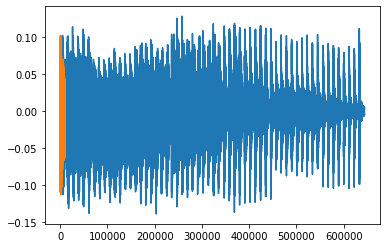

In [54]:
plt.plot(x1s[0][6800:-x2.shape[0]])
lll = ele_lengh[0]
plt.plot(x1s[0][lll:2*lll])
ipd.Audio(x1s[0][6800:2*lll],rate=sr2)

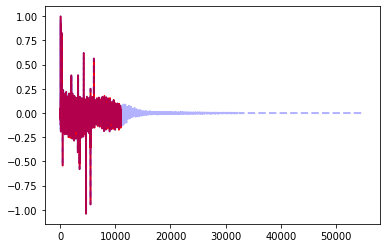

In [22]:
t1 = x1s[0][:ele_lengh[0]]
t2 = x2

t1 = t1/np.max(t1)
t2 = t2/np.max(t2)


plt.plot(t1,'r')
plt.plot(t2,'b--',linewidth=2, alpha=0.3)
ipd.Audio(t1,rate=sr1s[0])

In [23]:
ipd.Audio(t2,rate=sr2)

In [24]:
# print(len(range(ele_lengh[0],len(x1s[0]),ele_lengh[0])))
# np.linspace(0,len(f),60,dtype=np.int32)
# for i in range(len(x1s)):
  # print(len(x1s[i])/ele_lengh[i])

NameError: ignored

In [25]:
l = []
for fn,f in enumerate(tqdm(x1s)):
  r = ele_lengh[fn]
  sp = np.linspace(0,len(f),60,dtype=np.int32)
  for i in range(len(sp)):
    if i>0: 
      if np.abs(np.min(f)-np.max(f)) > 1e-3:
        if(np.abs(np.min(f[sp[i-1]:sp[i]])-np.max(f[sp[i-1]:sp[i]]))) > 1e-3:
          # print(counter)
          l.append([f[sp[i-1]:sp[i]],sr1s[fn], midi_notes[fn][i]])
        # print(len(notes))
  # l= np.array(l)
a=[]
for i in range(len(l)):
  if not l[i][0].shape[0] in a:
    a.append(l[i][0].shape[0]) 


100%|██████████| 88/88 [00:01<00:00, 56.41it/s]


In [26]:
len(l)

3469

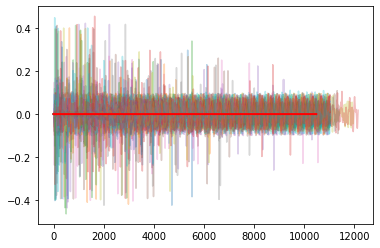

In [27]:
# a,ele_lengh
for i in range(len(x1s)):
  if not  i ==3:
    plt.plot(x1s[i][:ele_lengh[i]],alpha=0.3)
plt.plot(x1s[3][:ele_lengh[3]],'r',linewidth=2)
plt.show()
ipd.Audio(x1s[3][:ele_lengh[3]],rate=sr1s[3])

In [28]:
import pickle

In [29]:
with open(audio_path+"all-notes.dat",'wb') as f:
  pickle.dump(l,f)
  f.close()